# 最优百分位方法

#### —— 从集合数值模式降水中提取最优预报信息

国家气象中心天气预报技术研发室  
代刊, June, 2021  

#### Objectives
* 了解最优百分位的计算原理；
* 利用最优百分位方法进行实际运算。

---

In [2]:
# set up things
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# load necessary libraries
# you should install cartopy with 'conda install -c conda-forge cartopy'
import pickle
from pathlib import Path
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec

# load nmc_met_io for retrieving micaps server data
from nmc_met_io.retrieve_micaps_server import get_model_grid, get_model_grids
from nmc_met_graphics.plot.china_map import add_china_map_2cartopy

xr.set_options(display_style="text")

## 最优百分位方法原理
---

最优百分位方法（代刊等，2016）基于预报经验，通过长时间检验发现不同的集合预报百分位值对不同降水等级的降水具有预报优势，例如对于24 h时效暴雨（≥50 mm）通常90%分位值具有很好的指导意义。

<img src="./images/optimal_percentile_01.png" alt="image" style="height: 500px;">

Best TS score ensemble statistic for different grades:  
* ≥0.1mm: ensemble minimum or 0% percentile;
* ≥10mm: ensemble middle or 50% percentile;
* ≥25mm: 75% percentile;
* ≥50mm: 90% percentile;
* ≥100mm: ensemble maximum or 100% percentile.
*These results are robust in other years for 1-day forecast.*  

Constructing fusing statistics from member forecasts (MF). For each grid point, fusing value FV is set to：
* if 100%(MF) ≥100, then FV=100%(MF) and return, else continue; 
* if 90%(MF)  ≥ 50, then FV = 90%(MF) and return, else continue ;
* if 75%(MF)  ≥ 25, then FV = 75%(MF) and return, else continue;
* if 50%(MF)  ≥ 10, then FV = 50%(MF) and return, else continue;
* else FV = 0%(MF) and return .
*FV have higher threat score than deterministic forecast for each precipitation grade.*

## 最优百分位方法的实现
---

<img src="./images/optimal_percentile_02.png" alt="image" style="height: 300px;">

<div class="alert alert-success">
    <b>EXERCISE</b>:
    最优百分位计算实习:
     <ul>
      <li>利用nmc_met_io中的函数从Micaps服务器上读取近期集合预报24h累积降水量数据.</li>
      <li>计算并显示集合平均值.</li>
      <li>构建最优百分位计算程序.</li>
      <li>以[0.0, 10, 25, 50, 100]为降水阈值，[0.0, 0.5, 0.75, 0.90, 0.95]为对应的最优百分位，计算显示最优百分位预报场.</li>
    </ul>
</div>

In [6]:
# read ECMWF ensemble forecast data from MICAPS server
filename = "21060220.036"
datafile = (Path('samples/ensemble_forecast/') / Path(filename))
if datafile.is_file():
    # load data file
    with open(datafile, 'rb') as f:
        data = pickle.load(f)
else:
    directory = "ECMWF_ENSEMBLE/RAW/RAIN24/"
    data = get_model_grid(directory, filename=filename, varname='precipitation',
                          varattrs={'long_name':'accumulated precipitation', 'units':'mm'},
                          cache=False)
    # save data to file
    with open(datafile, 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
data

<xarray.Dataset>
Dimensions:                  (lat: 121, lon: 261, number: 51, time: 1)
Coordinates:
  * number                   (number) int64 0 1 2 3 4 5 6 ... 45 46 47 48 49 50
  * time                     (time) datetime64[ns] 2021-06-04T08:00:00
  * lat                      (lat) float64 0.0 0.5 1.0 1.5 ... 59.0 59.5 60.0
  * lon                      (lon) float64 50.0 50.5 51.0 ... 179.0 179.5 180.0
    forecast_reference_time  datetime64[ns] 2021-06-02T20:00:00
    forecast_period          (time) float64 36.0
Data variables:
    precipitation            (number, time, lat, lon) float64 1.678 ... 0.06485
Attributes:
    Conventions:  CF-1.6
    Origin:       MICAPS Cassandra Server

In [8]:
#
# extract data information

# coordinates and values
lon = data.lon.values
lat = data.lat.values
x, y = np.meshgrid(lon, lat)
mem = data.number.values
values = np.squeeze(data.precipitation.values)

# time information
rtime = data.forecast_reference_time.values
fhour = int(data.forecast_period.values[0])
vtime = rtime + np.timedelta64(fhour, 'h')

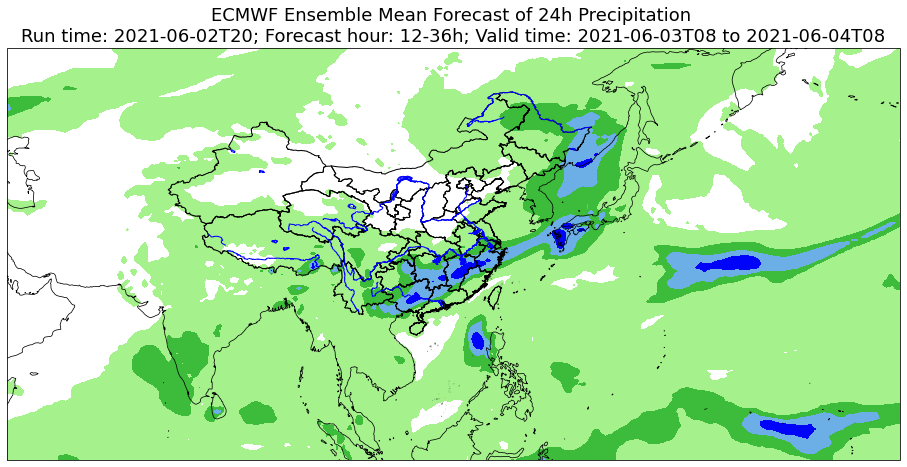

In [10]:
#
# draw ensemble mean

# set colors and levels
clevs = [0.1, 10, 25, 50, 100, 250]
colors = ['#a5f28d', '#3dbb3b', '#6caee6', '#0003fa', '#f804fc', '#7d0240']
cmap, norm = mpl.colors.from_levels_and_colors(clevs, colors, extend='max')

# set figure and subplot size
datacrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(16, 12))
ax = plt.subplot(111, projection=datacrs)

# draw ensemble mean
ens_mean = values.mean(axis=0)    # calculate ensemble mean
plot = ax.contourf(x, y, ens_mean, clevs, norm=norm, cmap=cmap, transform=datacrs, extend="max")
add_china_map_2cartopy(ax, name='province', edgecolor='k', lw=1)
add_china_map_2cartopy(ax, name='river', edgecolor='blue', lw=1)
ax.coastlines('50m', edgecolor='grey', linewidth=0.75)
title = (
    "ECMWF Ensemble Mean Forecast of 24h Precipitation \n"
    "Run time: {}; Forecast hour: {}h; Valid time: {}").format(
        np.datetime_as_string(rtime, unit="h"),
        str(fhour-24)+'-'+str(fhour),
        np.datetime_as_string(vtime-np.timedelta64(24,'h'), unit="h")+' to '+
        np.datetime_as_string(vtime, unit="h"))
plt.title(title, fontsize=18)
plt.show()

```Python

# 定影降水阈值及其最优百分位值
thresholds = [0.0, 10, 25, 50, 100]
optimal_quant = [0.0, 0.5, 0.75, 0.90, 0.95]

# 定义最优百分位计算函数
def optimal_quantiles_cal(values, thresholds, optimal_quant):
    """
    Calculate optimal quantiles for ensemble forecasts.

    Args:
        values (np.array): ensemble forecasts, shape=(ensemble_members, lat, lon)
        thresholds (np.array): 1D array, precipiation thresholds, increase order, like [0.0, 10, 25, 50, 100]
        optimal_quant (np.array): 1D array, optimal quantiles which corresponding to each threshold.

    Returns:
        np.array: probability-matched ensemble mean array, shape=(lat, lon)
    """

    # get dimensions
    _, nlat, nlon = values.shape

    # reverse order
    thresholds = list(reversed(thresholds))
    optimal_quant = list(reversed(optimal_quant))
    values_cal = np.full((nlat, nlon), np.nan)

    # loop each threshold ..., complete the code
    
    return values_cal

# 计算最优百分位值
values_cal = optimal_quantiles_cal(values, thresholds, optimal_quant)
```

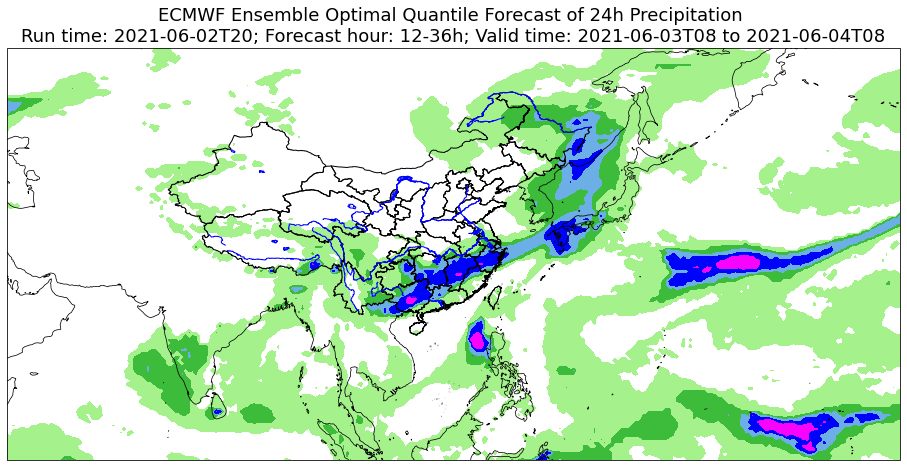

In [42]:
#
# draw ensemble mean

# set colors and levels
clevs = [0.1, 10, 25, 50, 100, 250]
colors = ['#a5f28d', '#3dbb3b', '#6caee6', '#0003fa', '#f804fc', '#7d0240']
cmap, norm = mpl.colors.from_levels_and_colors(clevs, colors, extend='max')

# set figure and subplot size
datacrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(16, 12))
ax = plt.subplot(111, projection=datacrs)

# draw ensemble mean
plot = ax.contourf(x, y, values_cal, clevs, norm=norm, cmap=cmap, transform=datacrs, extend="max")
add_china_map_2cartopy(ax, name='province', edgecolor='k', lw=1)
add_china_map_2cartopy(ax, name='river', edgecolor='blue', lw=1)
ax.coastlines('50m', edgecolor='grey', linewidth=0.75)
title = (
    "ECMWF Ensemble Optimal Quantile Forecast of 24h Precipitation \n"
    "Run time: {}; Forecast hour: {}h; Valid time: {}").format(
        np.datetime_as_string(rtime, unit="h"),
        str(fhour-24)+'-'+str(fhour),
        np.datetime_as_string(vtime-np.timedelta64(24,'h'), unit="h")+' to '+
        np.datetime_as_string(vtime, unit="h"))
plt.title(title, fontsize=18)
plt.show()